## 2. 神经网络的应用
  我们已经使用了原生代码实现了卷积神经网络，现在我们要使用TensorFlow来实现，然后应用到手势识别中，在这里我们要实现4个函数，一起来看看吧~
## 2.1.0 TensorFlow模型
我们先来导入库：

In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.python.framework import ops

from cnn_utils import *

%matplotlib inline
np.random.seed(1)

d:\python 3.6\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
d:\python 3.6\lib\site-packages\tensorflow\python\framework\dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
d:\python 3.6\lib\site-packages\tensorflow\python\framework\dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
d:\python 3.6\lib\site-packages\tensorflow\python\framework\dtypes.py:522: FutureWarning: Passing (type, 1) or '1type' as a synonym of type

In [2]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

y = 2


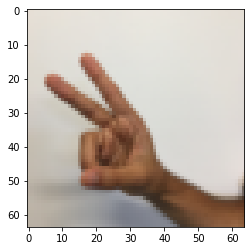

In [3]:
index = 6
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))


In [4]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


## 2.1 - 创建placeholders
TensorFlow要求您为运行会话时将输入到模型中的输入数据创建占位符。现在我们要实现创建占位符的函数，因为我们使用的是小批量数据块，输入的样本数量可能不固定，所以我们在数量那里我们要使用None作为可变数量。输入X的维度为**[None,n_H0,n_W0,n_C0]，对应的Y是[None,n_y]**。


In [5]:
def create_placeholders(n_H0, n_W0, n_C0,n_y):
    """
    为TensorFlow会话创建占位符
    参数：
        n_x - 一个实数，图片向量的大小（64*64*3 = 12288）
        n_y - 一个实数，分类数（从0到5，所以n_y = 6）
    
    返回：
        X - 一个数据输入的占位符，维度为[n_x, None]，dtype = "float"
        Y - 一个对应输入的标签的占位符，维度为[n_Y,None]，dtype = "float"
    
    提示：
        使用None，因为它让我们可以灵活处理占位符提供的样本数量。事实上，测试/训练期间的样本数量是不同的。
    
    """
    X = tf.placeholder(tf.float32, [None, n_H0, n_W0, n_C0])
    Y = tf.placeholder(tf.float32, [None, n_y])
    
    return X, Y

In [6]:
X , Y = create_placeholders(64,64,3,6)
print ("X = " + str(X))
print ("Y = " + str(Y))


X = Tensor("Placeholder:0", shape=(?, 64, 64, 3), dtype=float32)
Y = Tensor("Placeholder_1:0", shape=(?, 6), dtype=float32)


## 2.1.2 初始化参数
  现在我们将使用```tf.contrib.layers.xavier_initializer(seed = 0)``` 来初始化权值/过滤器$W1$、$W2$。在这里，我们不需要考虑偏置，因为TensorFlow会考虑到的。需要注意的是我们只需要初始化为2D卷积函数，全连接层TensorFlow会自动初始化的。


In [7]:
def initialize_parameters():
    """
    初始化权值矩阵，这里我们把权值矩阵硬编码：
    W1 : [4, 4, 3, 8]
    W2 : [2, 2, 8, 16]
    
    返回：
        包含了tensor类型的W1、W2的字典
    """
    tf.set_random_seed(1)
    
    W1 = tf.get_variable("W1", [4,4,3,8], initializer = tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable("W2", [2,2,8,16], initializer = tf.contrib.layers.xavier_initializer(seed=0))
    
    parameters = {
        "W1":W1,
        "W2":W2
    }
    
    return parameters

In [8]:
tf.reset_default_graph()
with tf.Session() as sess_test:
    parameters = initialize_parameters()
    init = tf.global_variables_initializer()
    sess_test.run(init)
    print("W1 = " + str(parameters["W1"].eval()[1,1,1]))
    print("W2 = " + str(parameters["W2"].eval()[1,1,1]))
    
    sess_test.close()


W1 = [ 0.00131723  0.1417614  -0.04434952  0.09197326  0.14984085 -0.03514394
 -0.06847463  0.05245192]
W2 = [-0.08566415  0.17750949  0.11974221  0.16773748 -0.0830943  -0.08058
 -0.00577033 -0.14643836  0.24162132 -0.05857408 -0.19055021  0.1345228
 -0.22779644 -0.1601823  -0.16117483 -0.10286498]


- **tf.nn.conv2d(X,W1, strides = [1,s,s,1], padding = 'SAME'):** given an input $X$ and a group of filters $W1$, this function convolves $W1$'s filters on X. The third input ([1,f,f,1]) represents the strides for each dimension of the input (m, n_H_prev, n_W_prev, n_C_prev). You can read the full documentation [here](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d)

- **tf.nn.max_pool(A, ksize = [1,f,f,1], strides = [1,s,s,1], padding = 'SAME'):** given an input A, this function uses a window of size (f, f) and strides of size (s, s) to carry out max pooling over each window. You can read the full documentation [here](https://www.tensorflow.org/api_docs/python/tf/nn/max_pool)

- **tf.nn.relu(Z1):** computes the elementwise ReLU of Z1 (which can be any shape). You can read the full documentation [here.](https://www.tensorflow.org/api_docs/python/tf/nn/relu)

- **tf.contrib.layers.flatten(P)**: given an input P, this function flattens each example into a 1D vector it while maintaining the batch-size. It returns a flattened tensor with shape [batch_size, k]. You can read the full documentation [here.](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/flatten)

- **tf.contrib.layers.fully_connected(F, num_outputs):** given a the flattened input F, it returns the output computed using a fully connected layer. You can read the full documentation [here.](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/fully_connected)
<br>
  使用tf.contrib.layers.fully_connected(F, num_outputs)的时候，全连接层会自动初始化权值且在你训练模型的时候它也会一直参与，所以当我们初始化参数的时候我们不需要专门去初始化它的权值。

我们实现前向传播的时候，我们需要定义一下我们模型的大概样子：: `CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED`.

我们具体实现的时候，我们需要使用以下的步骤和参数:
- Conv2d : 步伐：1，填充方式：“SAME”
- ReLU
- Max pool : 过滤器大小：8x8，步伐：8x8，填充方式：“SAME”
- Conv2d : 步伐：1，填充方式：“SAME”
- ReLU
- Max pool : 过滤器大小：4x4，步伐：4x4，填充方式：“SAME”
- 一维化上一层的输出
- 全连接层（FC）：使用没有非线性激活函数的全连接层。这里不要调用SoftMax， 这将导致输出层中有6个神经元，然后再传递到softmax。 在TensorFlow中，softmax和cost函数被集中到一个函数中，在计算成本时您将调用不同的函数。

In [23]:
def forward_propagation(X,parameters):
    """
    实现前向传播
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    参数：
        X - 输入数据的placeholder，维度为(输入节点数量，样本数量)
        parameters - 包含了“W1”和“W2”的python字典。
        
    返回：
        Z3 - 最后一个LINEAR节点的输出
    
    """
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    
    #Conv2d : 步伐：1，填充方式：“SAME”
    Z1 = tf.nn.conv2d(X, W1, strides = [1,1,1,1], padding = "SAME")

    #ReLu
    A1 = tf.nn.relu(Z1)
    
    #Max_pool: 过滤器大小：8x8，步伐：8x8，填充方式：“SAME”
    #这个SAME并不是维度不变，只是针对stride = 1,维度不变，如果stride！= 1，
    ##维度会变，只是计算的时候，不减去池化层本身的长度，宽度
    P1 = tf.nn.max_pool(A1, ksize=[1,8,8,1], strides = [1,8,8,1], padding = "SAME")
    
    #Conv2d : 步伐：1，填充方式：“SAME”
    Z2 = tf.nn.conv2d(P1, W2, strides=[1,1,1,1], padding = "SAME")
    
    #RuLe
    A2 = tf.nn.relu(Z2)
    
    #Max_pool:过滤器大小：4x4，步伐：4x4，填充方式：“SAME”
    P2 = tf.nn.max_pool(A2, ksize=[1,4,4,1], strides=[1,4,4,1], padding= "SAME")
    
    #一维化上一层的输出
    P = tf.contrib.layers.flatten(P2)
    
    #全连接层（FC）：使用没有非线性激活函数的全连接层
    Z3 = tf.contrib.layers.fully_connected(P, 6, activation_fn= None)
    
    return Z3

In [24]:
tf.reset_default_graph()


with tf.Session() as sess_test:
    np.random.seed(1)
    X,Y = create_placeholders(64,64,3,6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X,parameters)
    
    init = tf.global_variables_initializer()
    sess_test.run(init)
    
    a = sess_test.run(Z3,{X: np.random.randn(2,64,64,3), Y: np.random.randn(2,6)})
    print("Z3 = " + str(a))
    
    sess_test.close()
    

Z3 = [[ 1.4416984  -0.24909666  5.450499   -0.2618962  -0.20669907  1.3654671 ]
 [ 1.4070846  -0.02573211  5.08928    -0.48669922 -0.40940708  1.2624859 ]]


## 2.1.3 计算成本
我们要在这里实现计算成本的函数，下面的两个函数是我们要用到的：
- **tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y):** computes the softmax entropy loss. This function both computes the softmax activation function as well as the resulting loss. You can check the full documentation  [here.](https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits)
- **tf.reduce_mean:** computes the mean of elements across dimensions of a tensor. Use this to sum the losses over all the examples to get the overall cost. You can check the full documentation [here.](https://www.tensorflow.org/api_docs/python/tf/reduce_mean)

In [11]:
def compute_cost(Z3,Y):
    """
    计算成本
    参数：
        Z3 - 正向传播最后一个LINEAR节点的输出，维度为（6，样本数）。
        Y - 标签向量的placeholder，和Z3的维度相同
    
    返回：
        cost - 计算后的成本
    
    """
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))
    
    return cost

In [12]:
tf.reset_default_graph()

with tf.Session() as sess_test:
    np.random.seed(1)
    X,Y = create_placeholders(64,64,3,6)
    parameters =initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    
    init = tf.global_variables_initializer()
    sess_test.run(init)
    a = sess_test.run(cost,{X: np.random.randn(4,64,64,3), Y: np.random.randn(4,6)})
    print("cost=" + str(a))
    
    sess_test.close()
    

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

cost=4.6648693


## 2.1.4 构建模型
最后，我们已经实现了我们所有的函数，我们现在就可以实现我们的模型了。

我们之前在课程2就实现过random_mini_batches()这个函数，它返回的是一个mini-batches的列表。

在实现这个模型的时候我们要经历以下步骤：

- 创建占位符
- 初始化参数
- 前向传播
- 计算成本
- 反向传播
- 创建优化器

<br>
最后，我们将创建一个session来运行模型。


In [13]:
def model(X_train, Y_train, X_test, Y_test, learning_rate=0.002, 
         num_epochs=600,minibatch_size=64,print_cost=True,isPlot=True):
    """
    使用TensorFlow实现三层的卷积神经网络
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    参数：
        X_train - 训练数据，维度为(None, 64, 64, 3)
        Y_train - 训练数据对应的标签，维度为(None, n_y = 6)
        X_test - 测试数据，维度为(None, 64, 64, 3)
        Y_test - 训练数据对应的标签，维度为(None, n_y = 6)
        learning_rate - 学习率
        num_epochs - 遍历整个数据集的次数
        minibatch_size - 每个小批量数据块的大小
        print_cost - 是否打印成本值，每遍历100次整个数据集打印一次
        isPlot - 是否绘制图谱
        
    返回：
        train_accuracy - 实数，训练集的准确度
        test_accuracy - 实数，测试集的准确度
        parameters - 学习后的参数
    """
    ops.reset_default_graph() #能够重新运行模型而不覆盖tf变量
    tf.set_random_seed(1) #确保数据一样
    seed = 3              #指定numpy的随机种子
    (m, n_H0, n_W0, n_C0) = X_train.shape
    n_y = Y_train.shape[1]
    costs = []
    
    #为当前维度创建占位符
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    
    #初始化参数
    parameters = initialize_parameters()
    
    #前向传播
    Z3 = forward_propagation(X, parameters)
    
    #计算成本
    cost = compute_cost(Z3, Y)
    
    #反向传播，由于框架已经实现了反向传播，我们只需要选择一个优化器就行了
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    ##全局初始化所有变量
    init = tf.global_variables_initializer()
    
    #开始运行
    with tf.Session() as sess:
        #初始化参数
        sess.run(init)
        #开始遍历数据集
        for epoch in range(num_epochs):
            minibatch_cost = 0
            num_minibatches = int(m / minibatch_size) #获取数据块的数量
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
            
            #对每个数据块进行处理
            for minibatch in minibatches:
                #选择一个数据块
                (minibatch_X, minibatch_Y) = minibatch
                #最小化这个数据块的成本
                _, temp_cost = sess.run([optimizer, cost], feed_dict = {X:minibatch_X, Y: minibatch_Y})
                
                #累加数据块的成本值
                minibatch_cost += temp_cost/ num_minibatches
            #是否打印成本
            if print_cost:
                #每5代打印一次
                if epoch % 5 == 0:
                    print("当前是第 " + str(epoch) + " 代，成本值为：" + str(minibatch_cost))
            
            #记录成本
            if epoch % 1 == 0:
                costs.append(minibatch_cost)
        #数据处理完毕，绘制成本曲线
        if isPlot:
            plt.plot(np.squeeze(costs))
            plt.ylabel('cost')
            plt.xlabel('iterations (per tens)')
            plt.title("Learning rate =" + str(learning_rate))
            plt.show()
        
        #开始预测数据
        #计算当前的预测情况
        predict_op = tf.arg_max(Z3, 1)
        corrent_prediction = tf.equal(predict_op, tf.arg_max(Y, 1))
        
        ##计算准确度
        accuracy = tf.reduce_mean(tf.cast(corrent_prediction, "float"))
        print("corrent_prediction accuracy = " + str(accuracy))
        
        train_accuracy =accuracy.eval({X:X_train, Y:Y_train})
        test_accuracy = accuracy.eval({X:X_test, Y:Y_test})
        
        print("训练集准确度" + str(train_accuracy))
        print("测试集准确度：" + str(test_accuracy))
        
        return (train_accuracy,test_accuracy,parameters)

当前是第 0 代，成本值为：1.9430875852704048
当前是第 5 代，成本值为：1.8853117004036903
当前是第 10 代，成本值为：1.8207634538412094
当前是第 15 代，成本值为：1.583828143775463
当前是第 20 代，成本值为：1.2365427613258362
当前是第 25 代，成本值为：0.9803984127938747
当前是第 30 代，成本值为：0.8326572924852371
当前是第 35 代，成本值为：0.7125981189310551
当前是第 40 代，成本值为：0.6449509039521217
当前是第 45 代，成本值为：0.5749658774584532
当前是第 50 代，成本值为：0.5038022175431252
当前是第 55 代，成本值为：0.4677037615329027
当前是第 60 代，成本值为：0.4366893097758293
当前是第 65 代，成本值为：0.4121023565530777
当前是第 70 代，成本值为：0.38468840904533863
当前是第 75 代，成本值为：0.3831899333745241
当前是第 80 代，成本值为：0.3690601456910372
当前是第 85 代，成本值为：0.34088434278964996
当前是第 90 代，成本值为：0.2936348943039775
当前是第 95 代，成本值为：0.29628520272672176
当前是第 100 代，成本值为：0.2875769454985857
当前是第 105 代，成本值为：0.2586725018918514
当前是第 110 代，成本值为：0.235584560316056
当前是第 115 代，成本值为：0.23101983778178692
当前是第 120 代，成本值为：0.25805373303592205
当前是第 125 代，成本值为：0.22616659849882126
当前是第 130 代，成本值为：0.2182526746764779
当前是第 135 代，成本值为：0.20264602545648813
当前是第 140 代，成本值为：0.19541844632476568
当

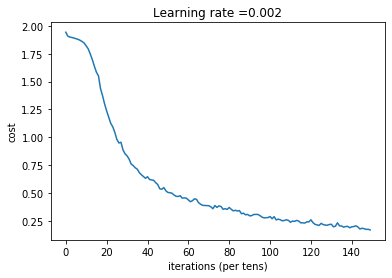

Instructions for updating:
Use `argmax` instead
corrent_prediction accuracy = Tensor("Mean_1:0", shape=(), dtype=float32)
训练集准确度0.9583333
测试集准确度：0.90833336


In [14]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test,num_epochs=150)
